# Tutoral: Output data

## Overview

The `pywrdrb.Output` class provides an easy method for loading and accessing Pywr-DRB model results.

## The pywrdrb.post.get_pywrdrb_results() Function

The `get_pywrdrb_results()` reads data from Pywr-DRB output files (`hdf5`) stored in the output directory and returns a dictionary of results along with a datetime index. 

This function is designed to handle different result types (`results_sets`), such as `"res_storage"`, `"major_flow"`, `"res_release"`, and more. This function makes it easy to extract specific variables, but it requires specifying each results_set separately and can be slow when constructing date indexes.

Old workflows required repeated calls of the `get_pywrdrb_results()` function for each type `results_set`. This was clunky:

## Usage of the `Output` Class

The `Output` class consolidates this entire process into a single `load()` method, automatically validating inputs, handling scenarios, and storing results inside the Ouput `object`.


### Output.load()

`Output.load()` uses `get_pywrdrb_results()` to fetch data for all specified `models` and `results_sets`. It manages datetime indexing and scenarios, and then stores the results as attributes within the class.

### Accessing Results Data

After using `Output.load()`, results are stored in the class as a nested dictionary structure:

```
Output.results_set[model][scenario]
```



In [1]:
import sys
path_to_pywrdrb = '../'
sys.path.append(path_to_pywrdrb)

In [2]:
from pywrdrb import Output

models = ['nhmv10', 'nwmv21']
results_sets = ['major_flow', 'res_storage', 'mrf_target', 'res_release']

output = Output(models, 
                results_sets = results_sets,
                base_results = False,
                print_status = True)
output.load()


## Access the data using format: 
# output.results_set[pywr_model][scenario]

output.major_flow['pywr_nhmv10'][0].head(1)

Loading major_flow data for nhmv10
Loading major_flow data for nwmv21
Loading res_storage data for nhmv10
Loading res_storage data for nwmv21
Loading mrf_target data for nhmv10
Loading mrf_target data for nwmv21
Loading res_release data for nhmv10
Loading res_release data for nwmv21


,01417000,01425000,01433500,01436000,01447800,01449800,01463620,01470960,delDRCanal,delLordville,delMontague,delTrenton,outletAssunpink,outletSchuylkill
1983-10-01,245.248604,192.037241,702.12651,216.100859,1296.612713,30.641998,77.324137,981.138761,872.861166,626.737443,1050.155248,804.943656,110.874962,329.747828


### Loading "base" results

We refer to base results for any non-pywrdrb data.  These base datasets include:
- Observations
- NHMv1.0 model outputs
- NWMv2.1 model outputs
- WRF-Hydro model outputs

For example, assume you want to compare the flows at Trenton between (1) observations, (2) pure NHM outputs, (3) PywrDRB simulated outputs using NHM input dat. In that case, those three data would be stored in:

1. output.major_flows['obs']
2. output.major_flows['nhmv10']
3. output.major_flows['pywr_nhmv10']

This notation is helpful because we are able to store all data in a single object. 

However, we need to be careful not to overwrite the existing data in the `output` object. 

In the block below, we:
- Change the `output.base_results` option to `True`
- Shorten the `output.results_sets` option, since the `base_results` have a limited set of valid options relative to pywrdrb simulation outputs. 

In [3]:

output.base_results = True
output.results_sets = ['major_flow', 'reservoir_downstream_gage']

output.load()

output.major_flow['nhmv10'][0].head(1)

Loading major_flow data for nhmv10
Loading major_flow data for nwmv21
Loading reservoir_downstream_gage data for nhmv10
Loading reservoir_downstream_gage data for nwmv21


,01425000,01417000,delLordville,01436000,01433500,delMontague,01449800,01447800,delDRCanal,delTrenton,01463620,outletAssunpink,01470960,outletSchuylkill
datetime,,,,,,,,,,,,,,
1983-10-01,133.939866,160.136252,483.527717,126.743131,49.516275,1067.390055,15.855123,91.194538,2082.226942,2082.226942,37.233799,70.784624,54.445733,526.051652


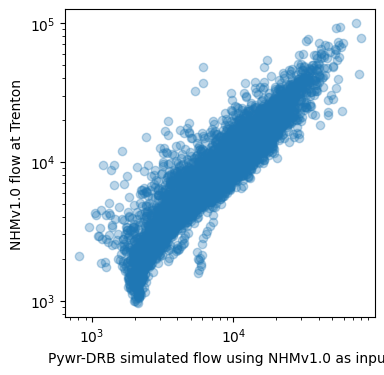

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.scatter(output.major_flow['pywr_nhmv10'][0].loc[:, 'delTrenton'], 
            output.major_flow['nhmv10'][0].loc[:, 'delTrenton'], alpha=0.3)
plt.ylabel('NHMv1.0 flow at Trenton')
plt.xlabel('Pywr-DRB simulated flow using NHMv1.0 as input')
plt.yscale('log')
plt.xscale('log')
plt.show()

### A note on reservoir stroage data

We only have access to reservoir storage data for the following cases:
- `"obs"`
- `f"pywr_{model}"`

I.e., we do not have storage data for "base" NHM, NWM, or WRF-Hydro models. This is simply because these models do not include reservoir operations by default.  

With that in mind, you will need to be carefull trying to run `pywrdrb.Output`, since `models=['nhmv10']` and `results_sets['res_storage'...]` will produce an error.  

Here is an example, retrieving observed reservoir storage:

Loading res_storage data for obs


<Axes: xlabel='datetime'>

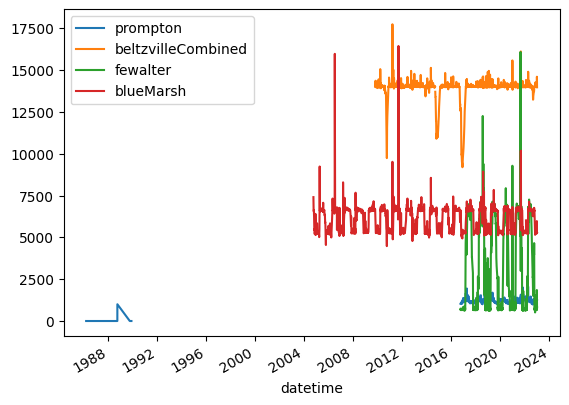

In [7]:
output.base_results = True
output.models = ['obs']
output.results_sets = ['res_storage']

output.load()

output.res_storage['obs'][0].plot()